## Import packages and setup paths

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import platform
from nat_zacros import lattice, state, trajectory

# Dictionary mapping usernames to data paths
user_paths = {
    'a-DJA'  : Path('c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations'),
    'akandra': Path('/home/akandra/O_Pt111/zacros_calculations'),
}

if platform.system() == 'Windows':
    username = os.getenv('USERNAME')
else:  # Linux/Mac
    username = os.getenv('USER')

# Get path for current user
if username in user_paths:
    dir_with_calculations = user_paths[username]
else:
    raise ValueError(f"Unknown user: {username}. Please add your username and path to user_paths dictionary.")

print(f"Operating System: {platform.system()}")
print(f"User            : {username}")
print(f"Data directory  : {dir_with_calculations.as_posix()}")

Operating System: Windows
User            : a-DJA
Data directory  : c:/Users/a-DJA/Dropbox/Surface_Reaction_Kinetics/O_Pt111/zacros_calculations


## Load job information from fn_3leed

In [2]:
# Set directories
log_dir = dir_with_calculations / 'fn_3leed'
data_dir = log_dir / 'jobs'
results_dir = log_dir / 'results'
log_file = data_dir / 'jobs.log'

# Verify the file exists
if not log_file.exists():
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load json log file
with open(log_file, 'r') as f:
    log_header = f.readline().split()  # Read header
    log_entries = [json.loads(line) for line in f if line.strip()]

Path.mkdir(results_dir, exist_ok=True)

# Parse job information
run_dirs = [data_dir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]

print(f"Found {len(run_dirs)} simulation runs")
print(f"First run: {run_dirs[0].name}")
print(f"  Temperature: {temperatures[0]} K")
print(f"  Coverage: {coverages[0]:.3f} ML")
print(f"  Interactions: {interactions[0]}")

Found 19 simulation runs
First run: 1
  Temperature: 50 K
  Coverage: 0.110 ML
  Interactions: 1nn-2nn-3nn-4nn-5nn-6nn-7nn-8nn-9nn-1-1-1-1-1-2-1-1-3-2-2-5-2-2-6-3-3-3-1-2-3


## Test trajectory class on first run

In [3]:
# Select first run as test case
rundir = run_dirs[0]
print(f"Testing with: {rundir}")

# Find all trajectory directories
traj_dirs = sorted([d for d in rundir.iterdir() if d.is_dir() and d.name.startswith('traj_')])
print(f"Found {len(traj_dirs)} trajectories")

# Test with first trajectory
if len(traj_dirs) > 0:
    test_traj_dir = traj_dirs[0]
    print(f"\nLoading trajectory from: {test_traj_dir.name}")
    
    # Create lattice
    lat = lattice(test_traj_dir)
    print(f"Lattice: {repr(lat)}")
    
    # Create trajectory and load states
    traj = trajectory(lat, test_traj_dir)
    traj.load_trajectory()
    print(f"\nTrajectory: {repr(traj)}")
    print(f"Loaded {len(traj)} states")
    
    if len(traj) > 0:
        print(f"\nFirst state: {repr(traj[0])}")
        print(f"Last state:  {repr(traj[-1])}")
else:
    print("No trajectory directories found!")

Testing with: c:\Users\a-DJA\Dropbox\Surface_Reaction_Kinetics\O_Pt111\zacros_calculations\fn_3leed\jobs\1
Found 10 trajectories

Loading trajectory from: traj_1
Lattice: lattice(type='periodic_cell', size=(np.int64(40), np.int64(40)), nsites=1600, area=11028.04)

Trajectory: trajectory(nstates=199, t=[0.00, 198.00], lattice=1600 sites)
Loaded 199 states

First state: state(nsites=1600, n_adsorbates=176, coverage=0.110)
Last state:  state(nsites=1600, n_adsorbates=176, coverage=0.110)


## Plot energy vs time for first run
This reproduces cell 58 from zacros_analyze.ipynb for the first case

In [4]:
# --------------------------------------------------------------------------
# ------        Load all trajectories using trajectory class          ------
# --------------------------------------------------------------------------

rundir = run_dirs[0]  # First run

# Get list of trajectory directories
traj_dirs = sorted([d for d in rundir.iterdir() if d.is_dir() and d.name.startswith('traj_')])

if len(traj_dirs) == 0:
    print("No trajectory directories found!")
    trajs = []
else:
    print(f"Loading {len(traj_dirs)} trajectories (energy only mode)...")
    
    # Create lattice (same for all trajectories in this run)
    lat = lattice(traj_dirs[0])
    
    # Load all trajectories with energy_only=True for fast loading
    # This skips parsing full state configurations and only extracts time/energy
    trajs = []
    for traj_dir in traj_dirs:
        traj = trajectory(lat, traj_dir)
        traj.load_trajectory(load_energy=True, energy_only=True)
        trajs.append(traj)
    
    print(f"Successfully loaded {len(trajs)} trajectories")
    print(f"Example: {repr(trajs[0])}")
    print(f"States in trajectory: {len(trajs[0].times)} time/energy points")

Loading 10 trajectories (energy only mode)...
Successfully loaded 10 trajectories
Example: trajectory(nstates=200, t=[0.00, 562984394862342710615165585354467049472.00], lattice=1600 sites)
States in trajectory: 200 time/energy points


## Bin and average energy across trajectories

In [5]:
# --------------------------------------------------------------------------
# ------        Bin energy data for plotting                          ------
# --------------------------------------------------------------------------

n_time_bins = 100

# Determine common time range
end_time = min([traj.times[-1] for traj in trajs])
print(f"Common time range: 0 to {end_time:.2e} s")

# Create time bins
time_bins = np.linspace(0, end_time, n_time_bins + 1)
time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
energy_hist = np.zeros(n_time_bins)

# Accumulate energy from all trajectories
for traj in trajs:
    times, energies = traj.get_energy_vs_time()
    
    # Bin the energy values
    for time, energy in zip(times, energies):
        if time <= end_time:
            bin_index = np.digitize(time, time_bins, right=False) - 1
            if 0 <= bin_index < n_time_bins:
                energy_hist[bin_index] += energy

# Average over trajectories
energy_hist /= len(trajs)

print(f"Binned energy data from {len(trajs)} trajectories")

Common time range: 0 to 4.69e+38 s
Binned energy data from 10 trajectories


## Plot energy vs time
This reproduces cell 58 from zacros_analyze.ipynb for the first case

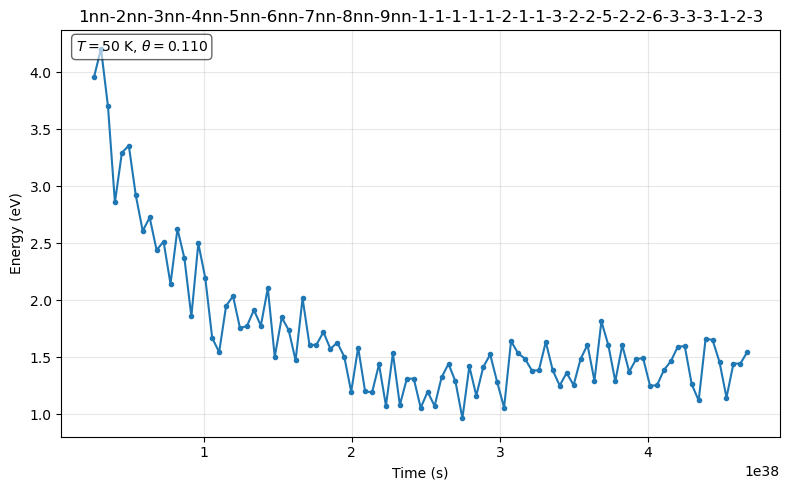


Energy statistics (after 50% equilibration):
  Mean:   1.3913 eV
  Std:    0.1828 eV
  Min:    0.9664 eV
  Max:    1.8168 eV


In [6]:
# --------------------------------------------------------------------------
# ------        Plot energy vs time                                   ------
# --------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(8, 5))

# Skip first few bins (may be initialization artifacts)
skip_bins = 5
ax.plot(time_bin_centers[skip_bins:], energy_hist[skip_bins:], 
        marker='o', linestyle='-', markersize=3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Energy (eV)')
ax.set_title(f'{interactions[0]}')
ax.text(0.02, 0.98, fr'$T={temperatures[0]}$ K, $\theta={coverages[0]:.3f}$',
        transform=ax.transAxes,
        va='top', ha='left',
        fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimate equilibration point
eq_fraction = 0.5
eq_bin = int(eq_fraction * n_time_bins)

print(f"\nEnergy statistics (after {eq_fraction*100:.0f}% equilibration):")
print(f"  Mean:   {np.mean(energy_hist[eq_bin:]):.4f} eV")
print(f"  Std:    {np.std(energy_hist[eq_bin:]):.4f} eV")
print(f"  Min:    {np.min(energy_hist[eq_bin:]):.4f} eV")
print(f"  Max:    {np.max(energy_hist[eq_bin:]):.4f} eV")

## Test equilibration methods

Original trajectory: 200 states
Equilibrated trajectory: 100 states

Full trajectory energy:
  Mean: 1.3818 eV
  Std:  1.0593 eV

Equilibrated trajectory energy:
  Mean: 1.1615 eV
  Std:  0.0285 eV


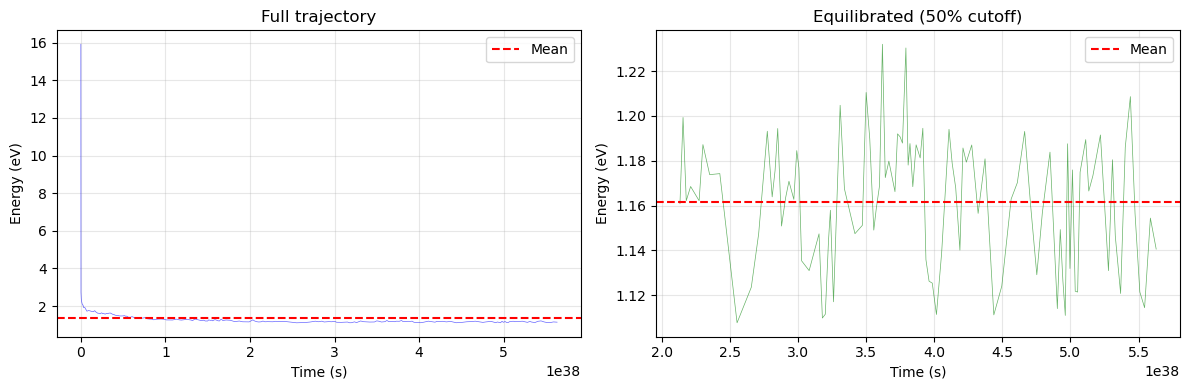

In [7]:
# --------------------------------------------------------------------------
# ------        Test equilibrated slice functionality                 ------
# --------------------------------------------------------------------------

# Take first trajectory as example
traj_test = trajs[0]

print(f"Original trajectory: {len(traj_test)} states")

# Get equilibrated slice
traj_eq = traj_test.get_equilibrated_slice(fraction=0.5)
print(f"Equilibrated trajectory: {len(traj_eq)} states")

# Compare energy statistics
times_full, energies_full = traj_test.get_energy_vs_time()
times_eq, energies_eq = traj_eq.get_energy_vs_time()

print(f"\nFull trajectory energy:")
print(f"  Mean: {np.mean(energies_full):.4f} eV")
print(f"  Std:  {np.std(energies_full):.4f} eV")

print(f"\nEquilibrated trajectory energy:")
print(f"  Mean: {np.mean(energies_eq):.4f} eV")
print(f"  Std:  {np.std(energies_eq):.4f} eV")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Full trajectory
axes[0].plot(times_full, energies_full, 'b-', alpha=0.6, linewidth=0.5)
axes[0].axhline(np.mean(energies_full), color='r', linestyle='--', label='Mean')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Energy (eV)')
axes[0].set_title('Full trajectory')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Equilibrated only
axes[1].plot(times_eq, energies_eq, 'g-', alpha=0.6, linewidth=0.5)
axes[1].axhline(np.mean(energies_eq), color='r', linestyle='--', label='Mean')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Energy (eV)')
axes[1].set_title('Equilibrated (50% cutoff)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## RDF Analysis
Compute radial distribution function averaged over all trajectories

### Quick RDF test with 2 trajectories

In [8]:
import time

# RDF parameters
lattice_constant = 2.821135  # 1nn distance in Angstroms (Pt(111))
r_max = 40.0  # Angstrom
dr = 0.1  # Bin width

print("Computing reference RDF (g_ref) for full lattice...")
r_ref, g_ref = trajs[0].get_g_ref(r_max=r_max, dr=dr)

# Use only first 2 trajectories for quick testing
test_trajs = trajs[:2]
print(f"\nQuick test: Loading equilibrated states for {len(test_trajs)} trajectories...")

# Start timing
t_start = time.time()

# Reload each trajectory with full state data for equilibrated portion
for i, traj in enumerate(test_trajs):
    traj.load_equilibrated_states(fraction=0.5)

print(f"\nComputing RDF for each trajectory (sequential)...")

# Compute RDF for each trajectory
rdfs_test = []
for i, traj in enumerate(test_trajs):
    r, g = traj.get_rdf(r_max=r_max, dr=dr, g_ref=g_ref)
    rdfs_test.append(g)

# Average RDFs
g_avg_test = np.mean(rdfs_test, axis=0)
g_std_test = np.std(rdfs_test, axis=0)

# Convert to a_0 units
r_a0 = r / lattice_constant

t_elapsed = time.time() - t_start

print(f"\nQuick test completed in {t_elapsed:.2f} seconds")
print(f"  Averaged over {len(test_trajs)} trajectories")
print(f"  First peak location: {r_a0[np.argmax(g_avg_test[:20])]:.2f} a_0")
print(f"  First peak height: {np.max(g_avg_test[:20]):.3f}")

Computing reference RDF (g_ref) for full lattice...

Quick test: Loading equilibrated states for 2 trajectories...

Computing RDF for each trajectory (sequential)...

Quick test completed in 49.22 seconds
  Averaged over 2 trajectories
  First peak location: 0.02 a_0
  First peak height: 0.000


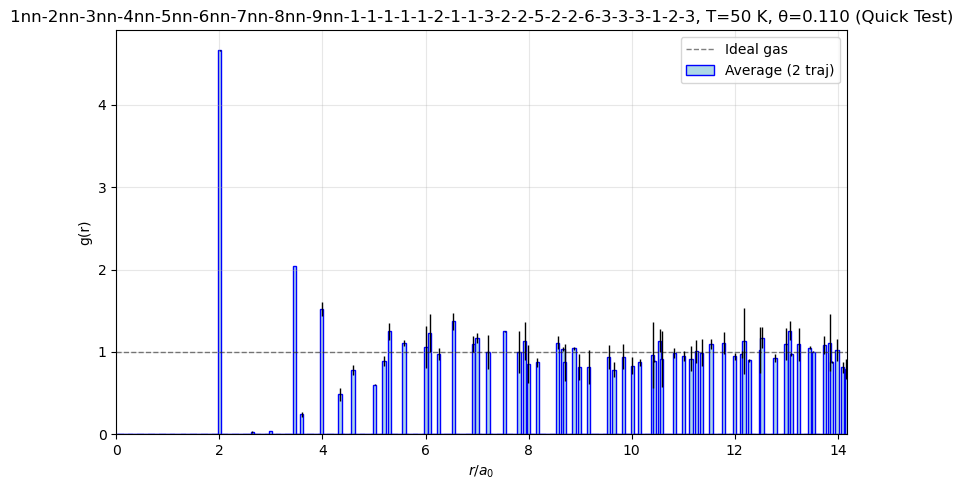

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate proper bar width based on bin spacing in a_0 units
bar_width = (dr / lattice_constant) * 1.8  # 180% of bin width

ax.bar(r_a0, g_avg_test, width=bar_width, ec='blue', fc='lightblue', 
       label=f'Average ({len(test_trajs)} traj)', align='center')
ax.errorbar(r_a0, g_avg_test, yerr=g_std_test, fmt='none', ecolor='black', 
            capsize=0, linewidth=1, zorder=10)
ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal gas')
ax.set_xlabel(r'$r / a_0$')
ax.set_ylabel('g(r)')
ax.set_title(f'{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f} (Quick Test)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, r_max/lattice_constant)
plt.tight_layout()
plt.show()

### Full RDF computation (all 10 trajectories) - Sequential

In [11]:
# RDF parameters (reuse from quick test if already defined)
if 'lattice_constant' not in locals():
    lattice_constant = 2.821135  # 1nn distance in Angstroms (Pt(111))
    r_max = 40.0  # Angstrom
    dr = 0.1  # Bin width
    print(f"Computing reference RDF (g_ref) for full lattice...")
    r_ref, g_ref = trajs[0].get_g_ref(r_max=r_max, dr=dr)

print(f"\nLoading equilibrated states for {len(trajs)} trajectories...")

# Time loading
t_load_start = time.time()

# Reload each trajectory with full state data for equilibrated portion
for i, traj in enumerate(trajs):
    print(f"  Loading trajectory {i+1}/{len(trajs)}...", end='\r')
    traj.load_equilibrated_states(fraction=0.5)

t_load = time.time() - t_load_start

print(f"\nComputing RDF for each trajectory (sequential)...")

# Time RDF computation
t_compute_start = time.time()

# Compute RDF for each trajectory (sequential)
rdfs = []
for i, traj in enumerate(trajs):
    print(f"  Computing RDF {i+1}/{len(trajs)}...", end='\r')
    r, g = traj.get_rdf(r_max=r_max, dr=dr, g_ref=g_ref)
    rdfs.append(g)

t_compute = time.time() - t_compute_start

# Average RDFs across all trajectories
g_avg = np.mean(rdfs, axis=0)
g_std = np.std(rdfs, axis=0)

# Convert distance to units of a_0
r_a0_seq = r / lattice_constant

print(f"\n\nSequential computation completed:")
print(f"  Loading time:   {t_load:.2f} seconds")
print(f"  Computing time: {t_compute:.2f} seconds")
print(f"  Total time:     {t_load + t_compute:.2f} seconds")
print(f"  Averaged over {len(trajs)} trajectories")


Loading equilibrated states for 10 trajectories...
  Loading trajectory 10/10...
Computing RDF for each trajectory (sequential)...
  Computing RDF 10/10...

Sequential computation completed:
  Loading time:   62.11 seconds
  Computing time: 301.56 seconds
  Total time:     363.67 seconds
  Averaged over 10 trajectories


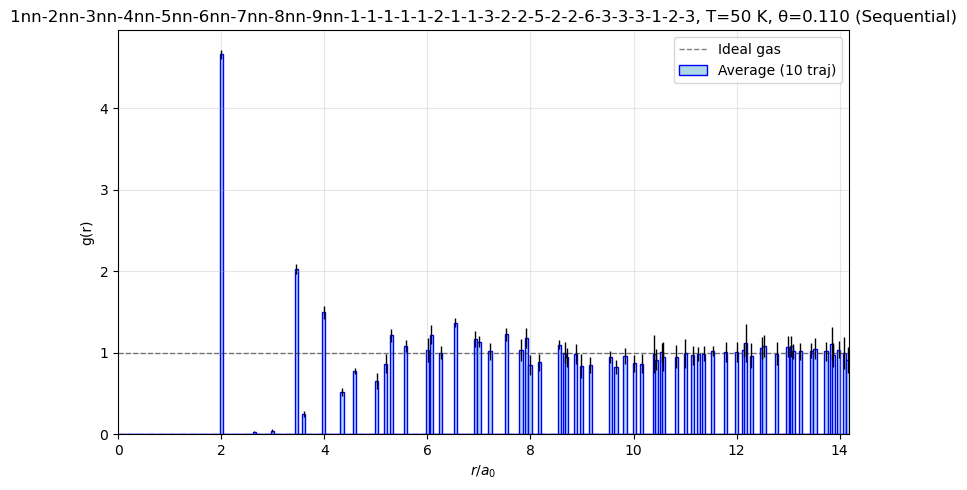

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate proper bar width based on bin spacing in a_0 units
bar_width = (dr / lattice_constant) * 1.8  # 180% of bin width

ax.bar(r_a0_seq, g_avg, width=bar_width, ec='blue', fc='lightblue', 
       label=f'Average ({len(trajs)} traj)', align='center')
ax.errorbar(r_a0_seq, g_avg, yerr=g_std, fmt='none', ecolor='black', 
            capsize=0, linewidth=1, zorder=10)
ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal gas')
ax.set_xlabel(r'$r / a_0$')
ax.set_ylabel('g(r)')
ax.set_title(f'{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f} (Sequential)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, r_max/lattice_constant)
plt.tight_layout()
plt.show()

### Full RDF computation (all 10 trajectories) - Parallel

In [16]:
import multiprocessing as mp

# Check available processors
n_cores = mp.cpu_count()
print(f"Available logical processors: {n_cores}")
print(f"Optimal workers for {len(trajs)} trajectories: ~{min(n_cores, len(trajs))}")

Available logical processors: 14
Optimal workers for 10 trajectories: ~10


In [18]:
from nat_zacros import compute_rdf_parallel

# Reload trajectories if states were cleared
if len(trajs[0].states) == 0:
    print(f"Reloading equilibrated states for {len(trajs)} trajectories...")
    for traj in trajs:
        traj.load_equilibrated_states(fraction=0.5)

print(f"\nComputing RDF using parallel processing...")

# Start timing
t_start = time.time()

# Parallel RDF computation - use all available cores (None = auto-detect)
r_parallel, g_avg_parallel, g_std_parallel = compute_rdf_parallel(
    trajs, r_max=r_max, dr=dr, g_ref=g_ref, n_workers=None
)

# Convert to a_0 units
r_a0_parallel = r_parallel / lattice_constant

t_elapsed = time.time() - t_start

print(f"\nParallel computation completed in {t_elapsed:.2f} seconds")
print(f"  Averaged over {len(trajs)} trajectories")
print(f"  First peak location: {r_a0_parallel[np.argmax(g_avg_parallel[:20])]:.2f} a_0")
print(f"  First peak height: {np.max(g_avg_parallel[:20]):.3f}")


Computing RDF using parallel processing...
Computing RDF for 10 trajectories using 14 workers...


Computing RDF: 100%|██████████| 10/10 [01:38<00:00,  9.89s/traj]



Successfully computed RDF averaged over 10 trajectories

Parallel computation completed in 125.29 seconds
  Averaged over 10 trajectories
  First peak location: 0.02 a_0
  First peak height: 0.000


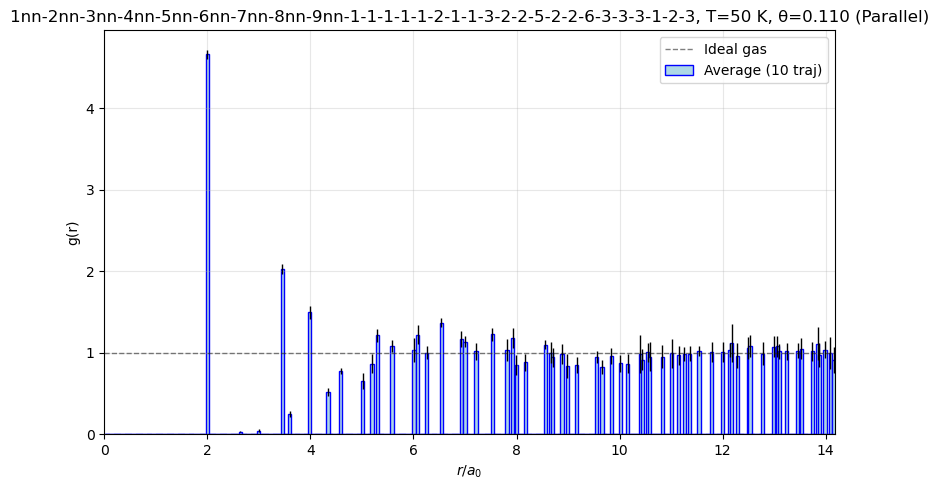

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))

# Calculate proper bar width based on bin spacing in a_0 units
bar_width = (dr / lattice_constant) * 1.8  # 180% of bin width

ax.bar(r_a0_parallel, g_avg_parallel, width=bar_width, ec='blue', fc='lightblue', 
       label=f'Average ({len(trajs)} traj)', align='center')
ax.errorbar(r_a0_parallel, g_avg_parallel, yerr=g_std_parallel, fmt='none', ecolor='black', 
            capsize=0, linewidth=1, zorder=10)
ax.axhline(1.0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Ideal gas')
ax.set_xlabel(r'$r / a_0$')
ax.set_ylabel('g(r)')
ax.set_title(f'{interactions[0]}, T={temperatures[0]} K, θ={coverages[0]:.3f} (Parallel)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, r_max/lattice_constant)
plt.tight_layout()
plt.show()